<a href="https://colab.research.google.com/github/86lekwenshiung/Multiclass-Image-Classification-with-CNN-in-Tensorflow/blob/main/Dog_Vision_Dog_Breed_Multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 End-to-End Multi-class Dog Breed Classification

This objective of this notebook is to build an end-to-end multi-class image clasifier using TensorFlow 2.0.
  * 1.0 : Data Feature
    * Unstructured Data
    * More than 120 classification 
    * More than 10,000 images in training set (Have labels)
    * More than 10,000 images in test set
  * 2.0 : Data Source
    * The data we are using is from Kaggle's dog breed indentification competition. 
    * https://www.kaggle.com/c/dog-breed-identification/data

  * 3.0 : Evaluation Metrics
    * Confusion Matrix
    * Accuracy & F1 Score
    * Training and Loss Curve

### **Libraries Import**
___

In [185]:
# Libraries Import

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from IPython.display import Image

from sklearn.model_selection import train_test_split

import os
import io
import datetime

### **Check GPU**
___

In [104]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF Version :' , tf.__version__)
print('TFhub_version :' , hub.__version__)
print('GPU is available' if tf.config.list_physical_devices('GPU') else 'Not Avaliable')

TF Version : 2.6.0
TFhub_version : 0.12.0
GPU is available


In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### General Function
___

In [106]:
def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs , loss , label = 'training loss')
  plt.plot(epochs , val_loss , label = 'validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label = 'training accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

In [107]:
# Refer to Tensorboard Doc String : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
def create_tensorboard_callback(dir_name , experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """

  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  
  print(f'Saving Tensorboard log files to {log_dir}')

  return tensorboard_callback

In [108]:
def walk_through_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f'There are {len(filenames)} files and {len(dirnames)} in {dirpath}')

In [256]:
def compare_loss_curves(history_old , history_new , epochs):
 
  # Define Original History
  loss = history_old.history['loss']
  accuracy = history_old.history['accuracy']

  val_loss = history_old.history['val_loss']
  val_accuracy = history_old.history['val_accuracy']

  # Define New History
  total_loss = loss + history_new.history['loss']
  total_accuracy = accuracy + history_new.history['accuracy']

  total_val_loss = val_loss + history_new.history['val_loss']
  total_val_accuracy = val_accuracy + history_new.history['val_accuracy']  

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(total_loss , label = 'training loss')
  plt.plot(total_val_loss , label = 'validation loss')
  plt.title('Train and Validation Loss')
  plt.xlabel('epochs')
  plt.axvline(x = epochs , 
             label = 'Start Fine Tuning',
             ymin = 0 ,
             ymax = 1,
             color = 'green')    
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(total_accuracy , label = 'training accuracy')
  plt.plot(total_val_accuracy , label = 'validation accuracy')
  plt.title('Train and Validation Accuracy')
  plt.xlabel('epochs')
  plt.axvline(x = epochs , 
             label = 'Start Fine Tuning',
             ymin = 0 ,
             ymax = 1,
             color = 'green')  
  plt.legend()

# 1.0 Getting Data for Dogs Images
___

In [109]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Multiclass-Image-Classification-with-CNN-in-Tensorflow/main/dataset/labels.csv

label_df = pd.read_csv('/content/labels.csv')
label_df.head()

--2021-09-28 16:48:00--  https://raw.githubusercontent.com/86lekwenshiung/Multiclass-Image-Classification-with-CNN-in-Tensorflow/main/dataset/labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482063 (471K) [text/plain]
Saving to: ‘labels.csv.1’

labels.csv.1        100%[===================>] 470.76K  --.-KB/s    in 0.03s   

2021-09-28 16:48:00 (13.4 MB/s) - ‘labels.csv.1’ saved [482063/482063]



id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [110]:
label_df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
golden_retriever         67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

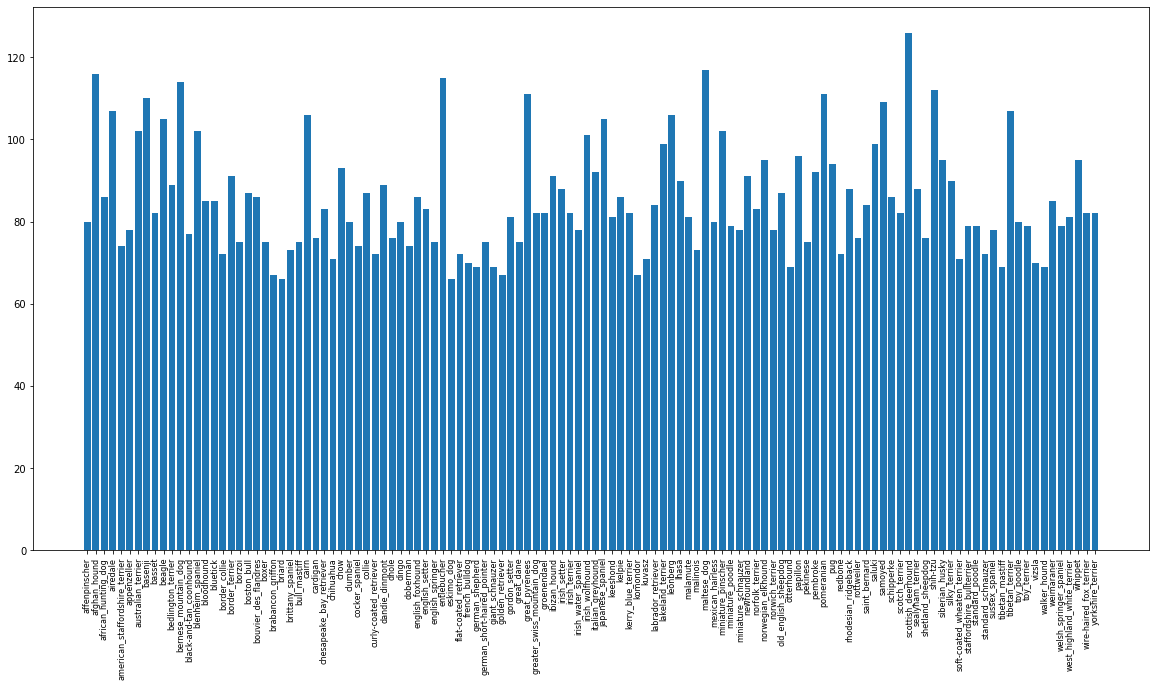

In [111]:
breed_df = label_df.groupby('breed' , as_index=False).count()
breed_df.columns = ['Breed' , 'Count']
plt.figure(figsize = (20,10))
plt.bar(x = 'Breed',
        height = 'Count',
        data = breed_df)
plt.xticks(rotation = 90 , fontsize = 8)
plt.show()

### 1.1 Exploring File Path
___

In [112]:
walk_through_dir('/content/drive/MyDrive/Colab Notebooks/dog_vision/train_data')

There are 10222 files and 0 in /content/drive/MyDrive/Colab Notebooks/dog_vision/train_data


### 1.2 Setting Up File Path
___

In [113]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/dog_vision/train_data'
test_dir = '/content/drive/MyDrive/Colab Notebooks/dog_vision/test_data'

In [114]:
# Image Could be obtained from https://www.kaggle.com/c/dog-breed-identification/data

filename = [train_dir + '/' + fname + '.jpg' for fname in label_df.id]
len(filename)

10222

In [115]:
print(f'There are {len(os.listdir(train_dir))} images in train_dir')
print(f'There are {len(os.listdir(test_dir))} images in test_dir')

There are 10222 images in train_dir
There are 10357 images in test_dir


In [116]:
if len(os.listdir(train_dir)) == len(filename):
  print('Filename quantity match amount of files')
else:
  print('Filename quantity do not match amount of files')

Filename quantity match amount of files


### 1.3 Setting up Class Name
___

In [117]:
# No. of Unique Dog Breed
print(f'There are {label_df["breed"].nunique()} of unique dog breed')
unique_breeds = label_df['breed'].unique()

There are 120 of unique dog breed


In [118]:
# Slicing Label for images
labels = label_df['breed']

In [119]:
# We can use that for the 30th image , the label is affenpinscher.
# From the 30th unique dog breed , the label is groenendael.

print(labels[30])
print(unique_breeds[30])
labels[30] == unique_breeds

affenpinscher
groenendael


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [120]:
bool_labels = [label == unique_breeds for label in labels]
bool_labels[0:2]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False,  True, False, False, False, Fal

In [121]:
print(labels[0]) # breed of dog from original df
print(np.where((unique_breeds) == labels[0])) # Check position on unique_breed array where it matches with breed of dog from labels
print(bool_labels[0].argmax()) # Check the 'nth' array in bool_labels and check where maximum value occur (true = 1 , false  = 0)
print(bool_labels[0].astype(int)) # Converting True / False into 1 & 0

boston_bull
(array([0]),)
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### 1.4 Visualing Images
___

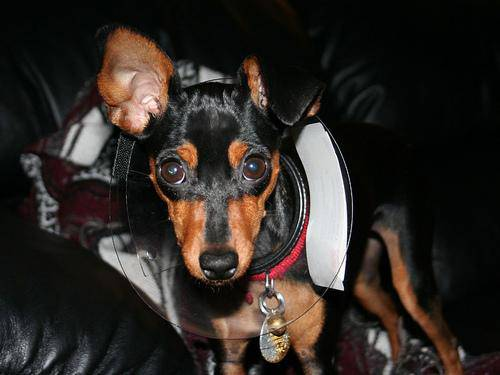

In [122]:
random_image = random.choice(filename)
Image(random_image)

# 2.0  **Processing Images (Turning Images into Tensors)**

1.   Load Data (From the filepath)
2.   User *tensorflow* to read the rile and save it to variable `image` `via io.read_file`
3.   Turn `image`(jpg) into tensors via`decode_jpeg`
4.   Normalise image into 0 and 1 via `convert_image_dtype`
5.   Resize `image` to shape (224 , 224)
6.   Return modified `image`









### 2.1 Create Function to load and prepare images
___

In [155]:
def load_process_image(filepath , img_shape = 224 , scale = False):

  """
  reads in an image from filename , turns it into a tensor and 
  reshapes into specified shape (img_shape , img_shape , color_channel = 3

  Args:
  filename(str) : path to target image
  image_shape (int) : height/width dimension to target image size
  scale (bool) : scale pixel values from 0 - 255 to 0 - 1
  """

  img = tf.io.read_file(filepath) # Load raw data as a string
  img = tf.image.decode_jpeg(img , channels = 3) # Convert compressed string to a 3D tensor
  img = tf.image.convert_image_dtype(img , tf.float32)
  img = tf.image.resize(img , size = [img_shape , img_shape])

  if scale :
    return img/255

  else:
    return img #EfficientNet Model no need to to rescale

### 2.2 Turning Data into Batches
___

* If we try to fit and process alot of photos, for example >10,000 images, they might not fit into the memory. 

* Optimal way is to do by batches of 32 at a time.

* In order to use tensorflow effectively, we need our data in the form of Tensor Tuples which look like (`image , label`)

In [157]:
def get_image_label(filepath , label):
  img = load_process_image(filepath)

  return img , label

In [158]:
BATCH_SIZE = 32

def create_data_batches(X , y=None , batch_size = BATCH_SIZE , valid_data = False , test_data = False):
  """
  Create batches of data out of image (X) and label (y) pairs
  Will shuffle data if it is training data
  Will not shuffle data if it is validation data
  Also accept test data as input (test_data has no label) 
  """
  # If input is a test dataset , will not have labels
  if test_data:
    print('Creating test data batches.. ')
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) #only filepath. (1) Create a source dataset from input (2)Apply dataset transformation (3)Iterrate over dataset and process element
    data_batch = data.map(load_process_image).batch(BATCH_SIZE)
    return data_batch
  # If input is a validation dataset , will not shuffle data
  elif valid_data:
    print('Creating Validation data batches..')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  # If input is a training dataset, will shuffle data
  else:
    print('Creating Training data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.shuffle(buffer_size = len(X))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

### 2.3 Splitting Dataset To a smaller Dataset for Pre-training
___

In [159]:
# Set up X and y variables
X = filename
y = bool_labels

len(filename) , len(bool_labels)

(10222, 10222)

In [160]:
NUM_IMAGES = 1000

X_subset = X[:NUM_IMAGES]
y_subset = y[:NUM_IMAGES]
X_train , X_val , y_train , y_val = train_test_split(X_subset, y_subset,
                                                     test_size = 0.2,
                                                     random_state = 42)

print('X_train Length : ' , len(X_train))
print('y_train Length : ' , len(y_train))
print('X_val Length : ' , len(X_val))
print('y_val Length : ' , len(y_val))

X_train Length :  800
y_train Length :  800
X_val Length :  200
y_val Length :  200


In [165]:
train_data = create_data_batches(X_train , y_train)
val_data = create_data_batches(X_val , y_val , valid_data = True)

Creating Training data batches...
Creating Validation data batches..
Size of Train Data :  25


In [163]:
# (1st array refer to img , 2nd array refer to label)
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

### 2.4 Visualising Processed Images
___

In [176]:
def sample_images(images , labels):
  plt.figure(figsize = (16,16))

  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])

    label = unique_breeds[np.argmax(labels[i])]
    plt.axis(False)
    plt.title(label)  

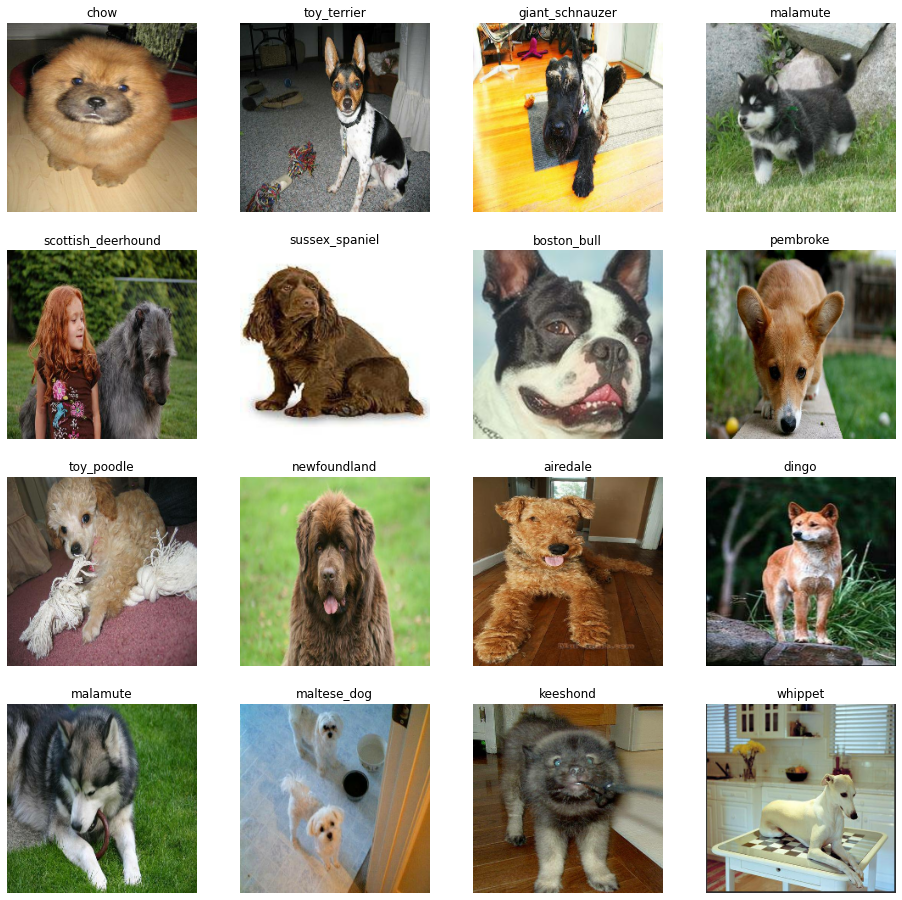

In [177]:
# Visualising Data for Training Dataset
# https://www.tensorflow.org/tutorials/load_data/images

train_images , train_labels = next(iter(train_data))

sample_images(train_images , train_labels)

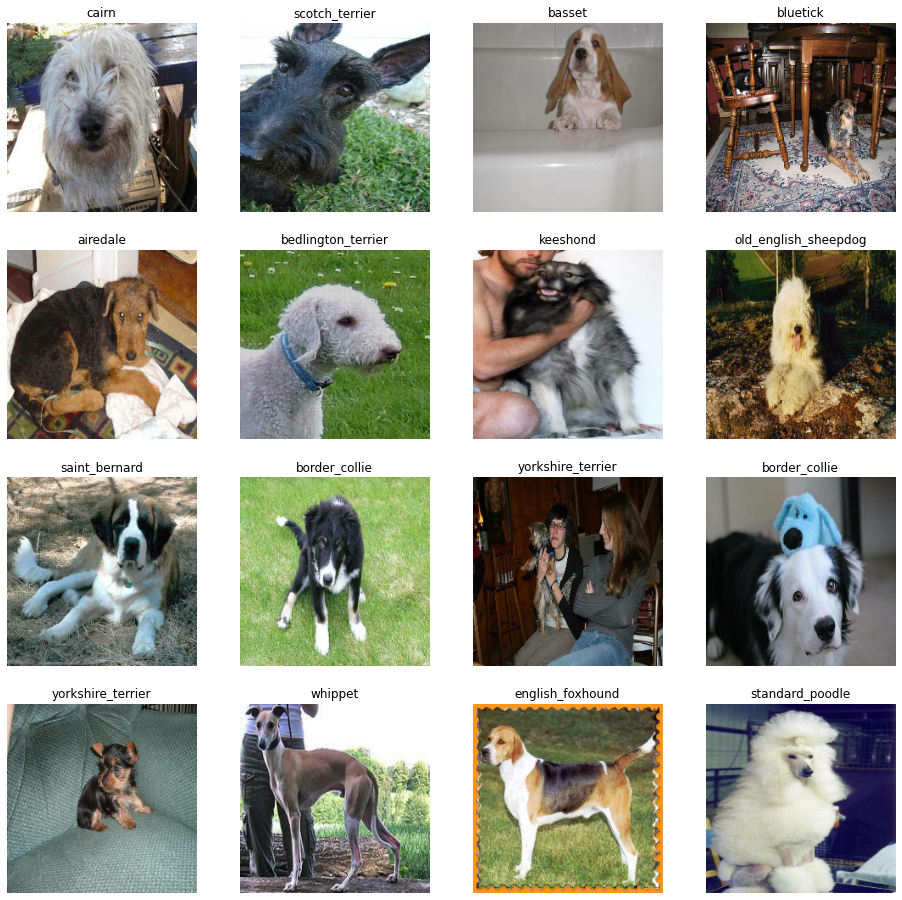

In [178]:
# Visualising Data for Validation Dataset
# https://www.tensorflow.org/tutorials/load_data/images

val_images , val_labels = next(iter(val_data))

sample_images(val_images , val_labels)

# 3.0 Creating Baseline Model from Transfer Learning (Mobilenet_v2)
___

* Take input shape , output shape and the choosen model.
* Define the layers in a `keras` model in sequential fashion(series way of execution)
* Compile the model(say it shoould be evaluated and improved)
* Build the model (tell the model the input shape it will be getting)
* Return the model

In [179]:
# batch , height , width , color channels
INPUT_SHAPE =  [None, 224, 224, 3] 

# 120 Unique Class
OUTPUT_SHAPE = len(unique_breeds) 

# Transfer learning from pretrained model mobilenet_v2
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5' 

In [180]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE , model_url = MODEL_URL):
  print('Building model with:' , MODEL_URL)
  
  # Setup Model Layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL),                   #input_layer 1
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                                                     activation = 'softmax') # Multi-class output
                               ])                                         
  
  #Compile the Model
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
               )
  
  # Build the Model
  model.build(INPUT_SHAPE)

  return model

In [181]:
sample = create_model()
sample.summary()
# Model route through imagenet to train the model

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### [3.1 Creating Early stopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)


In [191]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3,
                                                  min_delta = 0.01)

### 3.2 Fitting Data into Model
___
Our first model is going to train on 1000 images, to make sure everything is working.

In [196]:
def train_model():
  # Create a model (See Build Model Section)
  model = create_model()

  # Create Tensorboard (See Create Tensorboard callback function)

  history = model.fit(x = train_data,
            epochs = 100,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [create_tensorboard_callback('save_dir' , 'baseline_model') , early_stopping])
  
  return model , history

In [197]:
model , history = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Saving Tensorboard log files to save_dir/baseline_model/20210928-172845
Epoch 1/100
25/25 [==============================] - 11s 256ms/step - loss: 4.6988 - accuracy: 0.0825 - val_loss: 3.7367 - val_accuracy: 0.2050
Epoch 2/100
25/25 [==============================] - 5s 186ms/step - loss: 1.6829 - accuracy: 0.6712 - val_loss: 2.3528 - val_accuracy: 0.4600
Epoch 3/100
25/25 [==============================] - 5s 186ms/step - loss: 0.5732 - accuracy: 0.9312 - val_loss: 1.8362 - val_accuracy: 0.5400
Epoch 4/100
25/25 [==============================] - 5s 185ms/step - loss: 0.2551 - accuracy: 0.9900 - val_loss: 1.6391 - val_accuracy: 0.5750
Epoch 5/100
25/25 [==============================] - 4s 168ms/step - loss: 0.1497 - accuracy: 0.9962 - val_loss: 1.5605 - val_accuracy: 0.6000
Epoch 6/100
25/25 [==============================] - 5s 184ms/step - loss: 0.1016 - accuracy: 1.0000 - val_loss: 1.5048

### 3.3 Evaluating Results
___

In [209]:
model.evaluate(val_data)

7/7 [==============================] - 1s 118ms/step - loss: 1.4200 - accuracy: 0.6250


[1.4199928045272827, 0.625]

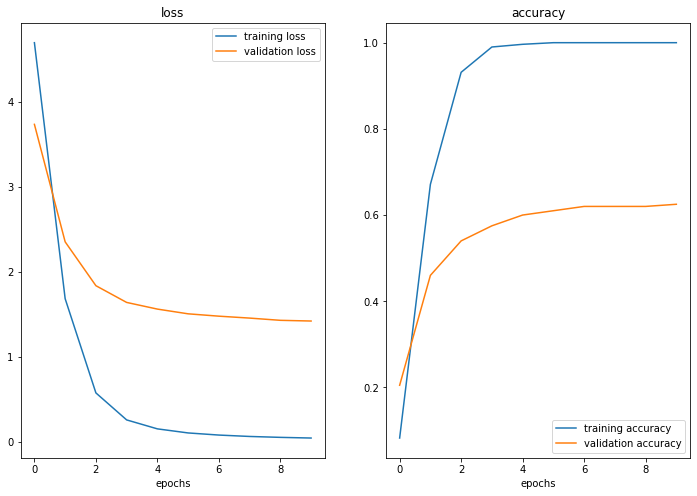

In [198]:
# Model Is very overfitted for the baseline model
plot_loss_curves(history)

In [ ]:
!tensorboard dev upload --logdir ./model_log/ \
  --name 'CNN Modelling with Dog Breed' \
  --description 'Training Results from mobilenet_v2' \
  --one_shot

**## Making Prediction and Evaluating model using trained model**

### 3.4 Visualising Prediction

In [212]:
# Making prediction on the validation data
prediction = model.predict(val_data)

In [213]:
np.sum(prediction[0]) 
# probability of each label. Total add up to 1
# Refer to softmax function : Each component will be in interval (0,1) and total will ad up to 1

0.99999994

In [214]:
index = 0

print(f'Max Value[Probability of Prediction]: {np.max(prediction[index])}')
print(f'Sum : {np.sum(prediction[index])}')
print(f'Index where Max Value Occur : :{prediction[index].argmax()}')
print(f'Predicted Labels: {unique_breeds[prediction[index].argmax()]}')

Max Value[Probability of Prediction]: 0.2505408227443695
Sum : 0.9999999403953552
Index where Max Value Occur : :33
Predicted Labels: border_terrier


In [215]:
def predict_label(predict_probabilities):

  return unique_breeds[predict_probabilities.argmax()] # to fit in with index, for example prediction[14]

In [216]:
predict_label(prediction[0])

'border_terrier'

### 3.5 Unbatching dataset
___

In [217]:
def unbatch_data(data):
  images = []
  labels = []
  for image , label in data.unbatch().as_numpy_iterator(): # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch
    images.append(image)
    labels.append(label)
  return images , labels

In [218]:
val_images , val_labels = unbatch_data(val_data)

In [ ]:
predict_label(labels[0]) , predict_label(prediction[0])

### 3.6 Visualising Test Prediction
* Convert prediction probabilities to a predicted label
* Plot predicted label , predicted probability
* Plot the truth label , and target image

In [220]:
def plot_pred(prediction_probabilities , images , labels , n =1):
  # Prediction Label 
  pred_prob = prediction_probabilities[n]
  pred_label = predict_label(pred_prob) # Goes back to predict_label function and return the predicted 'label' from validation data

  # Prediction Probability
  (np.max(prediction)*100).round(2)

  # True Label
  true = labels[n]
  true_label = predict_label(true) # Goes back to predict_label function and return the actual 'label' from validation data

  # Image function
  image = images[n]

  #Plotting Function
  plt.imshow(image)
  plt.axis('off')
  if true_label == pred_label:
    color = 'green'
  else:
    color = 'red'

  plt.title((f'{pred_label} vs {true_label} {(np.max(prediction)*100).round(2)}%'),
            color = color)

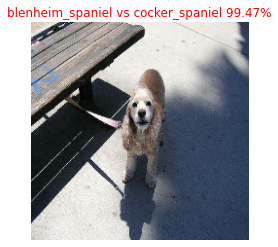

In [221]:
plot_pred(labels = val_labels,
          images = val_images,
          prediction_probabilities = prediction,
          n = 110)

#### 3.6.1 Build a function to show the probability of each label's prediction
* Find the prediction probabilities indexes
* Find the probabilities values
* Prediction labels

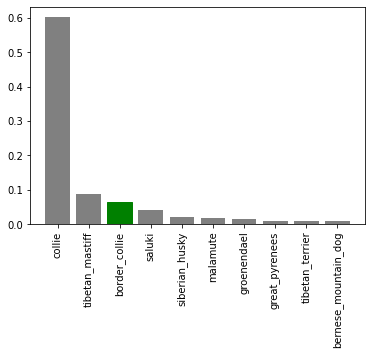

In [222]:
# Return top 10 prediction value's location (position)
top_10_pred_index = prediction[9].argsort()[-10:][::-1]

# Return top 10 index probabilities.
top_10_pred_prob = prediction[9][top_10_pred_index]

# Return top 10 prediction indexes
top_10_pred_labels = unique_breeds[top_10_pred_index]

#Plotting Result
top_10 = plt.bar(np.arange(len(top_10_pred_labels)), 
                 top_10_pred_prob,
                 color = 'grey')
plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

if np.isin(predict_label(val_labels[9]) , top_10_pred_labels):
  top_10[np.argmax(top_10_pred_labels == predict_label(val_labels[9]))].set_color('green')
else:
  pass

In [223]:
def plot_pred_conf(prediction_probabilities , labels ,n = 1):
  
  prediction_probabilities = prediction[n]
  true_label = labels[n]

  top_10_pred_index = prediction_probabilities.argsort()[-10:][::-1]
  top_10_pred_prob = prediction_probabilities[top_10_pred_index]
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  top_10 = plt.bar(np.arange(len(top_10_pred_labels)), 
                   top_10_pred_prob,
                   color = 'grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  if np.isin(predict_label(true_label) , top_10_pred_labels):
   top_10[np.argmax(top_10_pred_labels == predict_label(true_label))].set_color('green')
  else:
    pass


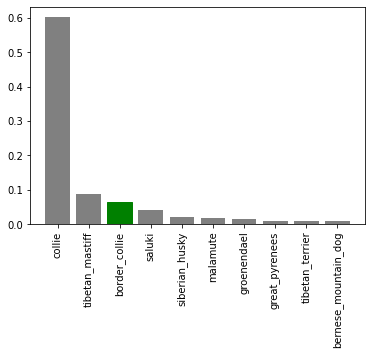

In [224]:
plot_pred_conf(prediction_probabilities = prediction , 
               labels = val_labels,
               n = 9)

#### 3.6.2 Check image with predicted value graph

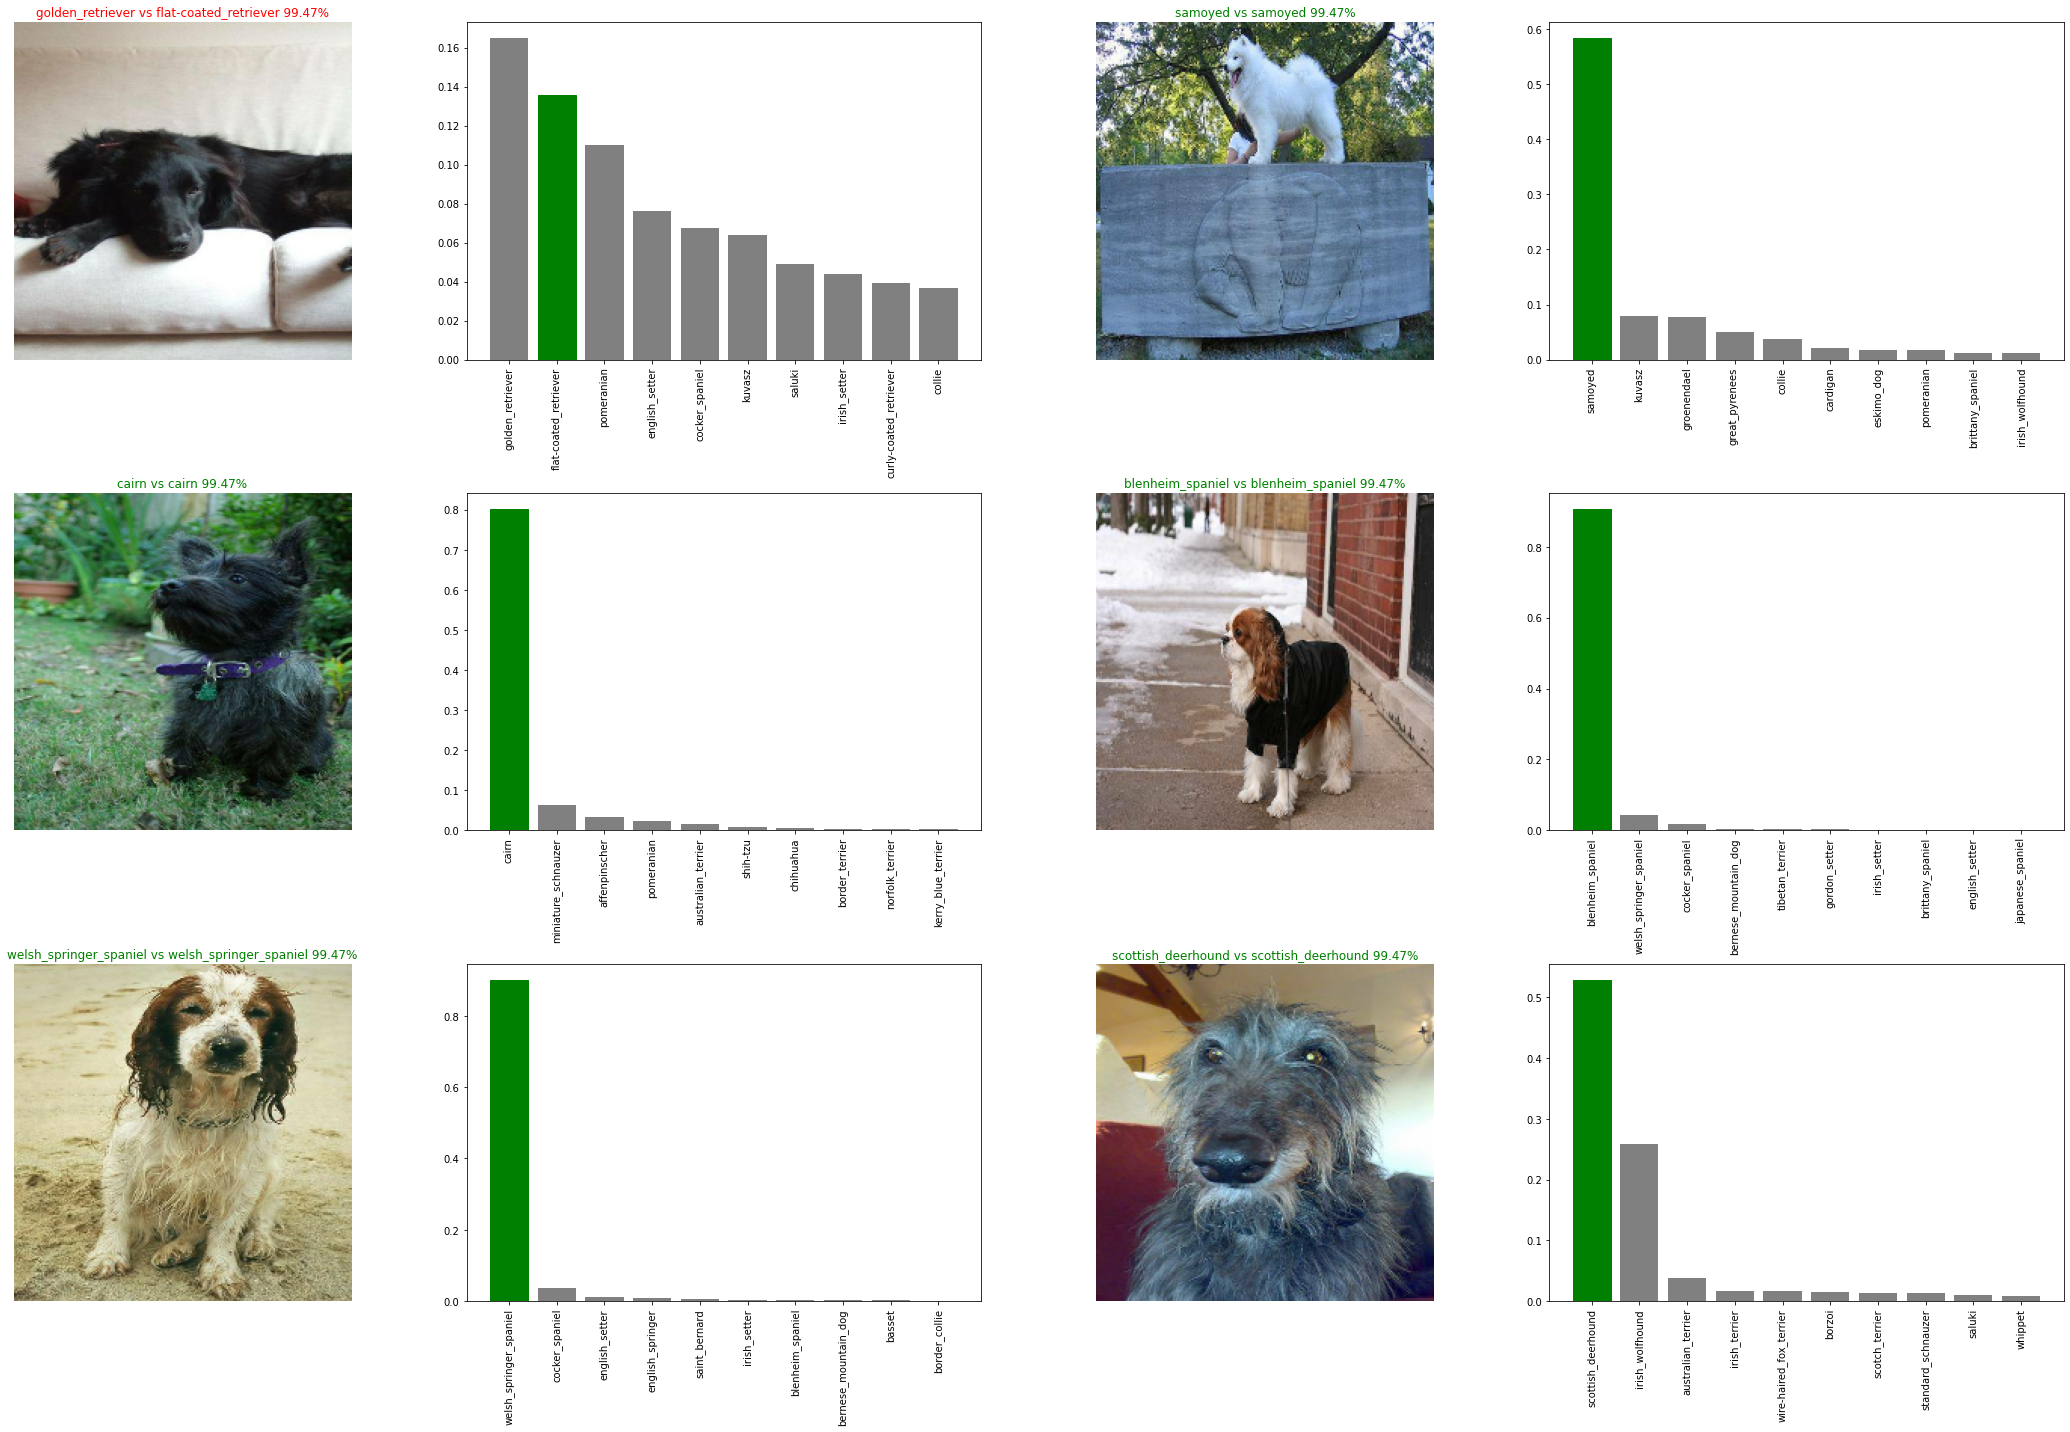

In [227]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize = (10*num_rows, 10*num_cols))

for i in range(num_images):
  plt.subplot(num_rows, num_cols*2 , 2*i+1)
  plot_pred(labels = val_labels,
            images = val_images,
            prediction_probabilities = prediction,
            n = i+i_multiplier)
  
  plt.subplot(num_rows, num_cols*2 , 2*i+2)
  plot_pred_conf(prediction_probabilities = prediction , 
                 labels = val_labels,
                 n = i+i_multiplier)
plt.tight_layout(h_pad = 1.0)
plt.show()

# 4.0 Saving and Reloading model

In [228]:
def save_model(model, suffix = None):
  modeldir = os.path.join('/content/drive/MyDrive/Colab_Notebooks/dog_vision/models',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + '.h5'
  print(f'Saving model to {model_path}...')
  model.save(model_path)
  return model_path


In [229]:
def load_model(model_path):

  print(f'Loading model to {model_path}...')

  # Refer to custom layer : custom layer for custom objects. Non Standard Dense Layer
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {'KerasLayer':hub.KerasLayer} ) 
  return model

In [230]:
save_model(model , suffix = '1000-images-mobilenetv2-Adam')

Saving model to /content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-17411632850891-.h5...


'/content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-17411632850891-.h5'

In [234]:
loaded_1000_model = load_model('/content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-17411632850891-.h5')

Loading model to /content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-17411632850891-.h5...


In [235]:
# Evaluating Pre-Saved Model
print('Original Model Score:',model.evaluate(val_data))
print('Loaded Model Score:',loaded_1000_model.evaluate(val_data))

7/7 [==============================] - 1s 120ms/step - loss: 1.4200 - accuracy: 0.6250
Original Model Score: [1.4199928045272827, 0.625]
7/7 [==============================] - 2s 124ms/step - loss: 1.4200 - accuracy: 0.6250
Loaded Model Score: [1.4199928045272827, 0.625]


# 5.0 Create Model with Full data
___
* Create Databatch
* Create Model
* Create callback tensorboard , early stopping
* Model.fit

In [236]:
len(X) , len(y)

(10222, 10222)

In [250]:
X_train , X_val , y_train , y_val = train_test_split(X, y,
                                                     test_size = 0.2,
                                                     random_state = 42)

print('X_train Length : ' , len(X_train))
print('y_train Length : ' , len(y_train))
print('X_val Length : ' , len(X_val))
print('y_val Length : ' , len(y_val))

X_train Length :  8177
y_train Length :  8177
X_val Length :  2045
y_val Length :  2045


In [251]:
train_data_full = create_data_batches(X_train , y_train)
val_data_full = create_data_batches(X_val , y_val , valid_data = True)

Creating Training data batches...
Creating Validation data batches..


In [252]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [253]:
full_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_8 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [254]:
history_2 = full_model.fit(x = train_data_full,
                          epochs = 20,
                          validation_data = val_data_full,
                          callbacks = [create_tensorboard_callback('save_dir' , 'full_model') , early_stopping])

Saving Tensorboard log files to save_dir/full_model/20210928-182302
Epoch 1/20
256/256 [==============================] - 49s 175ms/step - loss: 1.5080 - accuracy: 0.6370 - val_loss: 0.7231 - val_accuracy: 0.7917
Epoch 2/20
256/256 [==============================] - 42s 164ms/step - loss: 0.4153 - accuracy: 0.8793 - val_loss: 0.6522 - val_accuracy: 0.8108
Epoch 3/20
256/256 [==============================] - 42s 165ms/step - loss: 0.2376 - accuracy: 0.9403 - val_loss: 0.6342 - val_accuracy: 0.8152
Epoch 4/20
256/256 [==============================] - 44s 172ms/step - loss: 0.1514 - accuracy: 0.9660 - val_loss: 0.6552 - val_accuracy: 0.8068
Epoch 5/20
256/256 [==============================] - 44s 172ms/step - loss: 0.1020 - accuracy: 0.9825 - val_loss: 0.6657 - val_accuracy: 0.8098


### 5.1 Evaluating Test Result

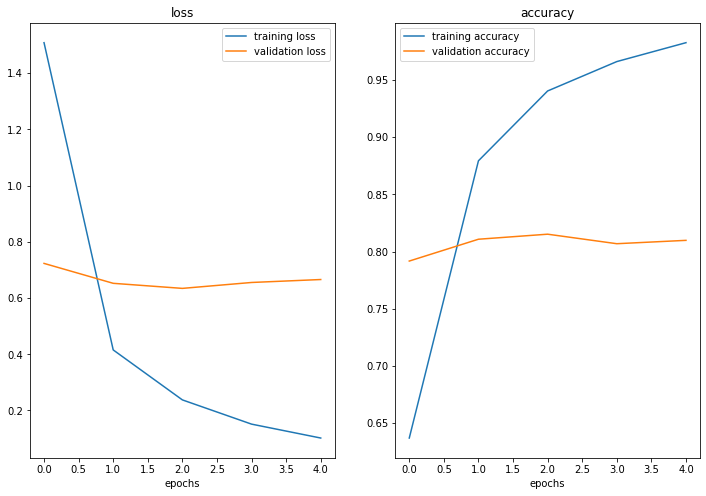

In [255]:
# Model 2 with 80% train dataset is still much overfitted , though performing much better than 1000 dataset
plot_loss_curves(history_2)

### 5.2 Saving full dataset model
___

In [260]:
save_model(full_model , suffix = 'full_dataset_mobilesetv2-Adam')

Saving model to /content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-18321632853932-.h5...


'/content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-18321632853932-.h5'

In [261]:
loaded_full_model  = load_model('/content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-18321632853932-.h5')

Loading model to /content/drive/MyDrive/Colab_Notebooks/dog_vision/models/20210928-18321632853932-.h5...


# 6.0 Preparing Test Dataset
___

In [270]:
# Setting up File Path for Test Image
test_filename = [test_dir + '/' + fname for fname in os.listdir(test_dir)]
test_filename[:5]

['/content/drive/MyDrive/Colab Notebooks/dog_vision/test_data/e7ed96b272013c6de9505a753816ce75.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog_vision/test_data/e7ce78e874945f182a4f5149aa505b09.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog_vision/test_data/e7afb35b8252782013a6700e28e327fa.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog_vision/test_data/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog_vision/test_data/e7afcce6e45858fc3b294cc5c0b15a53.jpg']

In [266]:
if len(test_filename) == len(os.listdir(test_dir)):
  print('Equal Dataset')
else:
  pass

Equal Dataset


In [267]:
# Creating Test data Batch
test_data = create_data_batches(test_filename , test_data = True)

Creating test data batches.. 


In [268]:
test_predictions = loaded_full_model.predict(test_data,
                                              verbose = 1)

324/324 [==============================] - 1123s 3s/step


In [269]:
test_predictions.shape

(10357, 120)

### 6.1 Preparing test dataset for kaggle

In [274]:
preds_df = pd.DataFrame(columns = ['id']+ list(unique_breeds))

In [277]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_dir)]
test_ids[:10]
preds_df['id'] = test_ids
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  boston_bull  ... cocker_spaniel   rottweiler
0  e7ed96b272013c6de9505a753816ce75  3.99577e-06  ...    2.35978e-07  2.30496e-07
1  e7ce78e874945f182a4f5149aa505b09  2.04588e-05  ...    9.59806e-08  1.04705e-06
2  e7afb35b8252782013a6700e28e327fa  5.74755e-07  ...    1.36283e-07  4.11993e-08
3  e7dc8cc599049ea9fa2a172c88646c57  4.37688e-05  ...    8.78419e-05  1.18066e-06
4  e7afcce6e45858fc3b294cc5c0b15a53  9.57298e-07  ...    6.87393e-07  4.67907e-08

[5 rows x 121 columns]

In [278]:
preds_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/dog_vision/full_model_prediction_kagglesub_mobilenetV2.csv',
                index = False)